In [739]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

### Download sequences

In [740]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   210  100   210    0     0    475      0 --:--:-- --:--:-- --:--:--   474
100 36.6M  100 36.6M    0     0  10.0M      0  0:00:03  0:00:03 --:--:-- 18.7M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   216  100   216    0     0    644      0 --:--:-- --:--:-- --:--:--   644
100 14.2M  100 14.2M    0     0  6960k      0  0:00:02  0:00:02 --:--:-- 15.2M
+ bash scripts/

In [741]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

In [742]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [743]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [744]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [745]:
df.reason.value_counts()

N                             307997
X                             217134
A[B.1.1.7]                     35832
A[B.1.617.2]                   35495
Y                              25541
                               ...  
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
A[B1.1.529]                        0
Name: reason, Length: 210, dtype: int64

In [746]:
import re

In [747]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    x = pd.crosstab(d.lineage.cat.remove_unused_categories() == "None", d.sequencing_pc).T
    #print((x[True] / x.sum(1)).sort_values())
    print(x)

lineage        False  True 
sequencing_pc              
1127.0            74      0
12489.0           55      0
1307.0          1123      2
13353.0          931      3
14467.0         2354      4
1458.0           945     14
16321.0         4248     20
17475.0         1353     16
20095.0         3951      6
20251.0          994      0
21502.0        11420     54
22081.0         2940      8
23845.0          203      0
30159.0         8916     13
30167.0           86      0
30449.0           69      0
3048.0           305      4
32105.0         1829     10
32545.0          763      2
32758.0          227      0
35043.0            3      0
37075.0          171      0
40210.0         3104     18
40225.0         4112     16
40477.0         1724      5
4103.0          1368     13
44137.0         8202      2
44879.0         4194    133
45147.0          315      5
4779.0         37219    596
50858.0        21070    236
50933.0         1926     38
55128.0            4      0
55131.0         1100

In [748]:
import re
d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")

IMS_ID
IMS-10294-CVDP-87A74412-A73F-4B65-AA1B-1D2F60BAD700    False
IMS-10294-CVDP-307E544A-42F4-487F-A925-D7A6E5A3D20E    False
IMS-10294-CVDP-7E903449-A7EF-4A04-8A14-278C1D6C6E68    False
IMS-10294-CVDP-59FB4C41-BD0E-48BC-AC35-73356B52044A    False
IMS-10294-CVDP-1A233FB2-B135-4F49-BFDF-AE612E2E9BF7    False
                                                       ...  
IMS-10280-CVDP-99B02515-7562-45EA-BB2C-87D66EDC9C5A    False
IMS-10280-CVDP-26043A7F-B937-4CC3-B6E2-FB8DFF8DB5F7    False
IMS-10280-CVDP-4B2F46B9-2BF1-44BE-8204-FEDC020940DA    False
IMS-10280-CVDP-254A4EF3-4576-46A6-8A24-3F676EE0A3BE    False
IMS-10280-CVDP-33B72BFB-43B4-4117-82D9-33C8AEC9CD57    False
Name: lineage, Length: 270022, dtype: bool

In [749]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.add_categories(['Other'])
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2']),"lineage"] = "Other"
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage.cat.remove_unused_categories(), dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[1,2,3,4,5,0]]
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-03-03     0       0     0     0      0          0
                  2022-03-04     1       0     1     0      0          0
                  2022-03-05     0       0     0     0      0          0
                  2022-03-06     0       0     0     0      0          0
                  2022-03-07     0       0     0     0      0          0

[2032 rows x 6 columns]

In [750]:
genomes.sum(level=0)

lineage                  BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland                                                         
Baden-Württemberg       15894   17358  7853     4     30      41413
Bayern                   2703    3945  2877     0     29       6202
Berlin                    701     692   778     0      5       2888
Brandenburg               910    1309   845     1      0       2851
Bremen                    183     316    43     0      5        837
Hamburg                  3952    3363  1192     3     23       3767
Hessen                    957    1483   469     2      1       1643
Mecklenburg-Vorpommern    563     549   400     0      0       2824
Niedersachsen             950    1052   481     0      6       3018
Nordrhein-Westfalen     19023   19649  8917    14    161      26429
Rheinland-Pfalz           292     255    69     0      2       1510
Saarland                  734    1033   193     0      4       1776
Sachsen                  4819    6833  2328     2     30      15056
Sachsen-Anhalt           1622     476   687     3      0       3003
Schleswig-Holstein       3105    4118  1902     4      2       3907
Thüringen                 309     544   134     0      8       1702

In [751]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [752]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [753]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [754]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-19   
                                    2020-03-13  2020-03-21   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A15-A34      W          2022-03-11  2022-03-11   
            A35-A59      W          2022-03-11  2022-03-11   
            A60-A79      W          2022-03-11  2022-03-11   
            A80+         W          2022-03-11  2022-03-11   
            unbekannt    W          2022-03-11  2022-03-11   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A15-A34      W          2022-03-11                     0   
            A35-A59      W          2022-03-11                     0   
            A60-A79      W          2022-03-11                     0   
            A80+         W          2022-03-11                     0   
            unbekannt    W          2022-03-11                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A15-A34      W          2022-03-11          1              -9   
            A35-A59      W          2022-03-11          1              -9   
            A60-A79      W          2022-03-11          1              -9   
            A80+         W          2022-03-11          1              -9   
            unbekannt    W          2022-03-11          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A15-A34      W          2022-03-11          -9          22   
            A35-A59      W          2022-03-11          -9          49   
            A60-A79      W          2022-03-11          -9          17   
            A80+         W          2022-03-11          -9          16   
            unbekannt    W          2022-03-11          -9           2   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

In [755]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

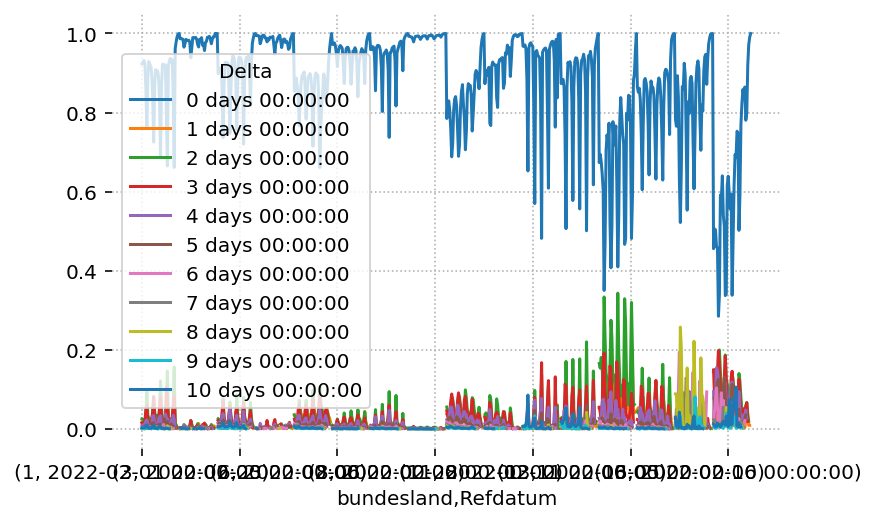

In [756]:
f.plot()

In [757]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [758]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [759]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.932137         0.949326         0.972721         0.986572   
Wed             0.931501         0.951182         0.973439         0.978450   
Thu             0.933272         0.952322         0.958295         0.963145   
Fri             0.927507         0.926189         0.935308         0.960496   
Sat             0.830603         0.841317         0.889317         0.951500   
Sun             0.700165         0.750064         0.870119         0.944283   
Mon             0.899808         0.926377         0.960293         0.979346   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.988975         0.990450         0.994448         0.996488   
Wed             0.981224         0.989283         0.994922         0.997185   
Thu             0.978786         0.991538         0.995778         0.997697   
Fri             0.981872         0.991639         0.994543         0.995805   
Sat             0.980302         0.988393         0.992168         0.991349   
Sun             0.972125         0.983300         0.983912         0.985479   
Mon             0.989328         0.990165         0.991734         0.994879   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.997663         0.998122               1.0  
Wed             0.998330         0.998713               1.0  
Thu             0.998642         0.997257               1.0  
Fri             0.996785         0.996925               1.0  
Sat             0.993022         0.994444               1.0  
Sun             0.991315         0.993842               1.0  
Mon             0.996901         0.998348               1.0

In [760]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [761]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [762]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999783  0.999754  0.999607  0.998943  0.998609   
Bayern                  0.997765  0.995331  0.991120  0.982878  0.971402   
Berlin                  0.996031  0.995518  0.982718  0.944943  0.992585   
Brandenburg             0.993079  0.990587  0.978578  0.946911  0.982463   
Bremen                  1.000000  1.000000  1.000000  0.998945  0.998799   
Hamburg                 1.000000  0.999256  0.998454  0.997811  0.997363   
Hessen                  0.999408  0.999055  0.998221  0.996188  0.994696   
Mecklenburg-Vorpommern  0.998127  0.997299  0.996180  0.989154  0.980092   
Niedersachsen           0.995311  0.993812  0.987919  0.968649  0.975927   
Nordrhein-Westfalen     0.998041  0.996323  0.994043  0.987529  0.983968   
Rheinland-Pfalz         0.999322  0.998791  0.996997  0.988987  0.994119   
Saarland                0.999311  0.999109  0.998667  0.993668  0.986951   
Sachsen                 0.998719  0.998025  0.995867  0.991874  0.990019   
Sachsen-Anhalt          0.998295  0.996852  0.973712  0.792180  0.871723   
Schleswig-Holstein      0.998642  0.995805  0.992168  0.983300  0.989328   
Thüringen               0.957774  0.978767  0.976212  0.942293  0.880053   

                               5         6         7         8  
Baden-Württemberg       0.998204  0.997397  0.996243  0.995111  
Bayern                  0.957841  0.939887  0.910307  0.868438  
Berlin                  0.989936  0.984432  0.976224  0.966957  
Brandenburg             0.979769  0.969488  0.956129  0.928739  
Bremen                  0.997436  0.996439  0.991438  0.991765  
Hamburg                 0.994013  0.992742  0.987234  0.984370  
Hessen                  0.993624  0.987823  0.980274  0.966623  
Mecklenburg-Vorpommern  0.977376  0.943899  0.847373  0.795173  
Niedersachsen           0.976477  0.966753  0.953228  0.939083  
Nordrhein-Westfalen     0.972254  0.956935  0.938448  0.906130  
Rheinland-Pfalz         0.989739  0.984055  0.978765  0.969933  
Saarland                0.988163  0.982507  0.964385  0.952668  
Sachsen                 0.984215  0.964982  0.933382  0.877406  
Sachsen-Anhalt          0.888036  0.906041  0.937958  0.910554  
Schleswig-Holstein      0.986572  0.973439  0.952322  0.927507  
Thüringen               0.883653  0.838087  0.762920  0.691879

In [763]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [764]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2143        2952        4427        4621   
Bayern                        5946        7033        9174        8949   
Berlin                        1325        1321        1441        1433   
Brandenburg                    812         982        1072        1058   
Bremen                          79          89          69          62   
Hamburg                        320         456         538         499   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1673        1370   
Nordrhein-Westfalen           2544        3416        4312        4314   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3669        3476        3312   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             335         390         366         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5071        4128        2276        4389   
Bayern                        9241        8800        7230        9345   
Berlin                        1450         967         753        2174   
Brandenburg                   1187        1119         978        1260   
Bremen                          55          55          31          60   
Hamburg                        554         467         410         476   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4044        3728        2893        4339   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3192        2665        4437   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         299         449   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-02  2022-03-03  \
bundesland                                      ...                           
Baden-Württemberg             7123        7755  ...       30282       31767   
Bayern                       11245       12151  ...       38789       36315   
Berlin                        1917        2395  ...        6579        6175   
Brandenburg                   1494        1686  ...        7342        6492   
Bremen                         143          95  ...        1052         828   
Hamburg                        520         554  ...        2317        2453   
Hessen                        1791        2067  ...       10676       11349   
Mecklenburg-Vorpommern         597         468  ...        5183        4645   
Niedersachsen                 1754        2165  ...       19067       18618   
Nordrhein-Westfalen           5132        5379  ...       37111       45023   
Rheinland-Pfalz               1139        1329  ...        8447       10107   
Saarland                       273         301  ...        2288        2767   
Sachsen                       5756        5987  ...       10802        9560   
Sachsen-Anhalt                1019        1178  ...        6973        6404   
Schleswig-Holstein             486         542  ...        5557       

In [765]:
cases_land.sum(0)

Refdatum
2021-11-01     22380
2021-11-02     27184
2021-11-03     32135
2021-11-04     31412
2021-11-05     32507
               ...  
2022-03-07    158095
2022-03-08    228982
2022-03-09    237632
2022-03-10    218813
2022-03-11    154928
Length: 131, dtype: int64

In [766]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2143        2952        4427        4621   
Bayern                        5946        7033        9174        8949   
Berlin                        1325        1321        1441        1433   
Brandenburg                    812         982        1072        1058   
Bremen                          79          89          69          62   
Hamburg                        320         456         538         499   
Hessen                        1193        1595        1705        1574   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1186        1453        1673        1370   
Nordrhein-Westfalen           2544        3416        4312        4314   
Rheinland-Pfalz                642         991        1127        1079   
Saarland                       127         123         203         230   
Sachsen                       2840        3669        3476        3312   
Sachsen-Anhalt                 647         856         721         738   
Schleswig-Holstein             335         390         366         354   
Thüringen                     1823        1430        1426        1502   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5071        4128        2276        4389   
Bayern                        9241        8800        7230        9345   
Berlin                        1450         967         753        2174   
Brandenburg                   1187        1119         978        1260   
Bremen                          55          55          31          60   
Hamburg                        554         467         410         476   
Hessen                        1688        1312        1092        1468   
Mecklenburg-Vorpommern         544         505         314         528   
Niedersachsen                 1400        1164         844        1621   
Nordrhein-Westfalen           4044        3728        2893        4339   
Rheinland-Pfalz               1027         808         764        1082   
Saarland                       185         214         155         209   
Sachsen                       3467        3192        2665        4437   
Sachsen-Anhalt                 729         658         899         670   
Schleswig-Holstein             436         382         299         449   
Thüringen                     1429        1755        1189        1856   

Refdatum                2021-11-09  2021-11-10  ...  2022-03-01  2022-03-02  \
bundesland                                      ...                           
Baden-Württemberg             7123        7755  ...       28743       30282   
Bayern                       11245       12151  ...       31505       38789   
Berlin                        1917        2395  ...        6470        6579   
Brandenburg                   1494        1686  ...        8190        7342   
Bremen                         143          95  ...         910        1052   
Hamburg                        520         554  ...        2661        2317   
Hessen                        1791        2067  ...        9792       10676   
Mecklenburg-Vorpommern         597         468  ...        5882        5183   
Niedersachsen                 1754        2165  ...       19496       19067   
Nordrhein-Westfalen           5132        5379  ...       34675       37111   
Rheinland-Pfalz               1139        1329  ...        9027        8447   
Saarland                       273         301  ...        2363        2288   
Sachsen                       5756        5987  ...       12282       10802   
Sachsen-Anhalt                1019        1178  ...        6917        6973   
Schleswig-Holstein             486         542  ...        5774       

In [767]:
C = cases_land.values

In [768]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [807]:
from genomicsurveillance.misc import fused_basis
B0 = fused_basis(C.shape[1]+clip, inc=10, fuse=5) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 

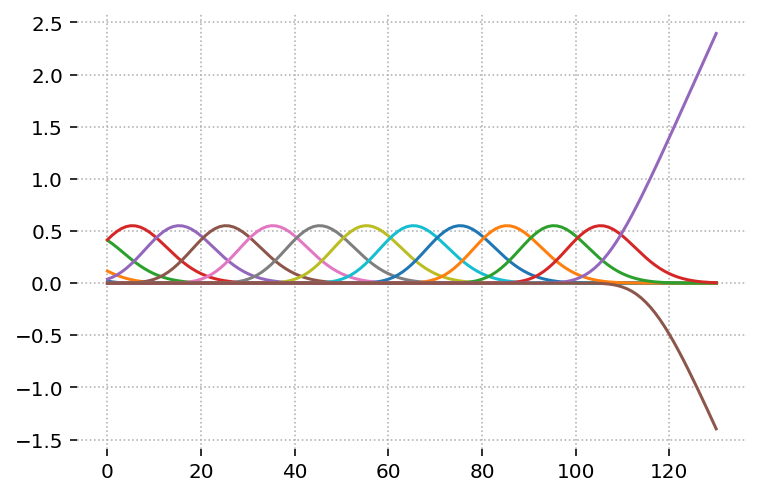

In [808]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

In [809]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [810]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [811]:
from numpyro.infer import Trace_ELBO

In [812]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [813]:
CC[2,-3] = np.nan 

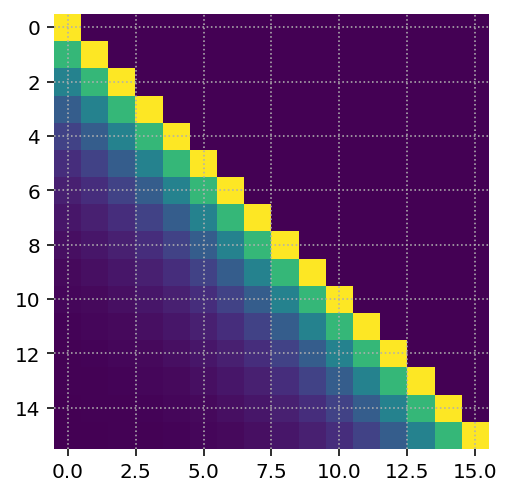

In [814]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

In [815]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.001,
    b0_scale=0.3,
    c_scale=20,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    fit_logits=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [816]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

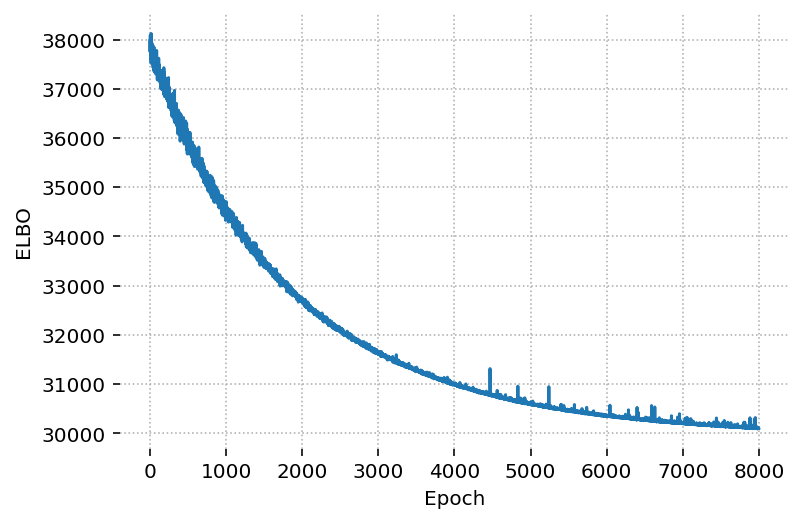

In [817]:
plt.plot(model.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

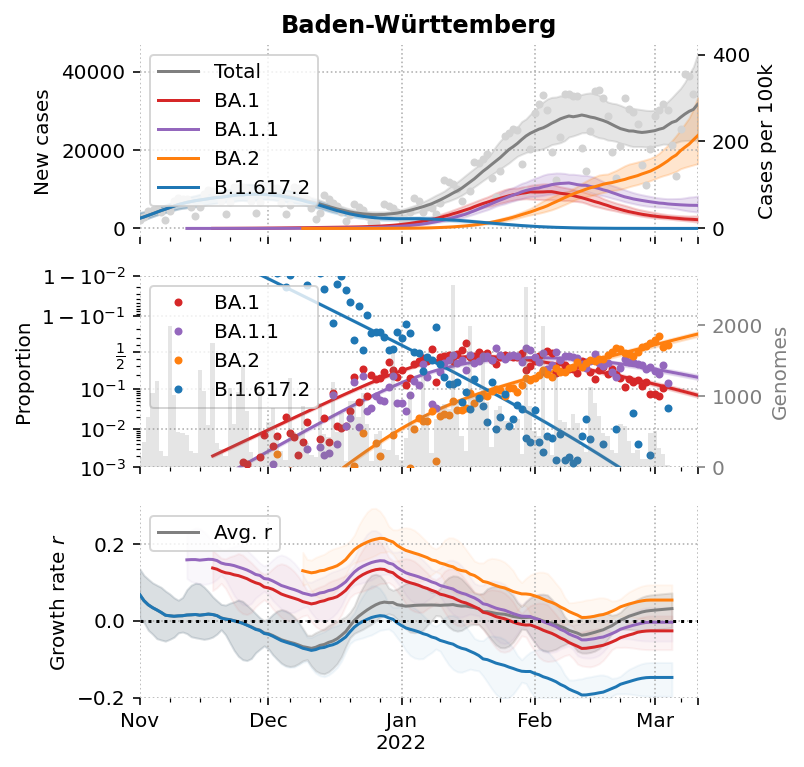

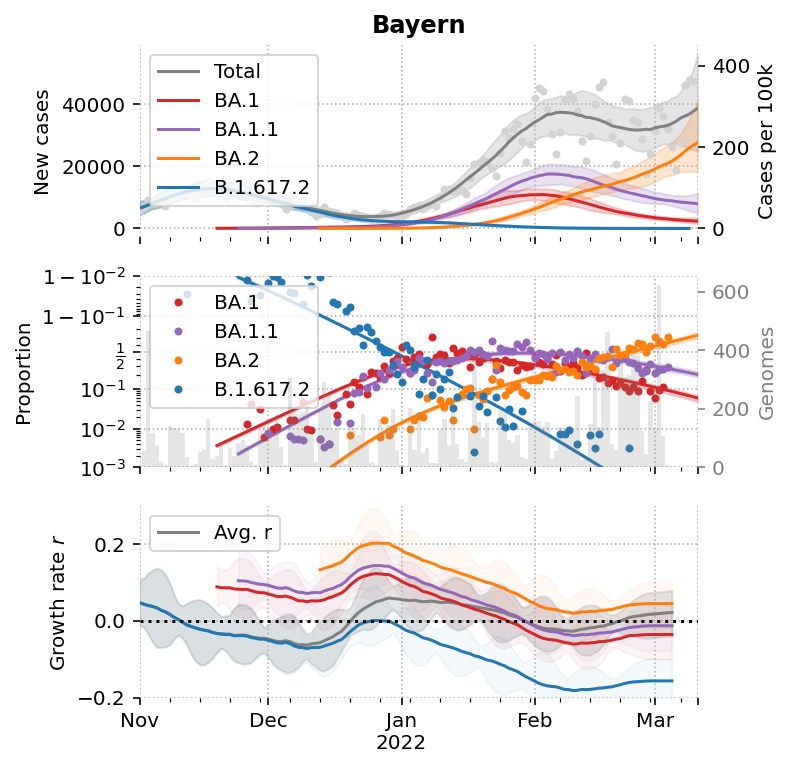

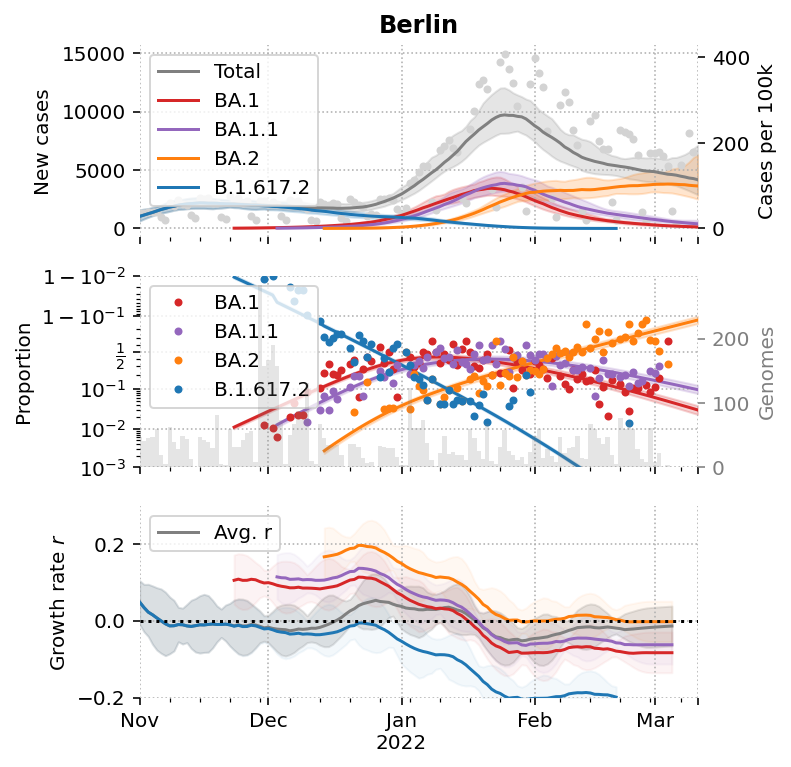

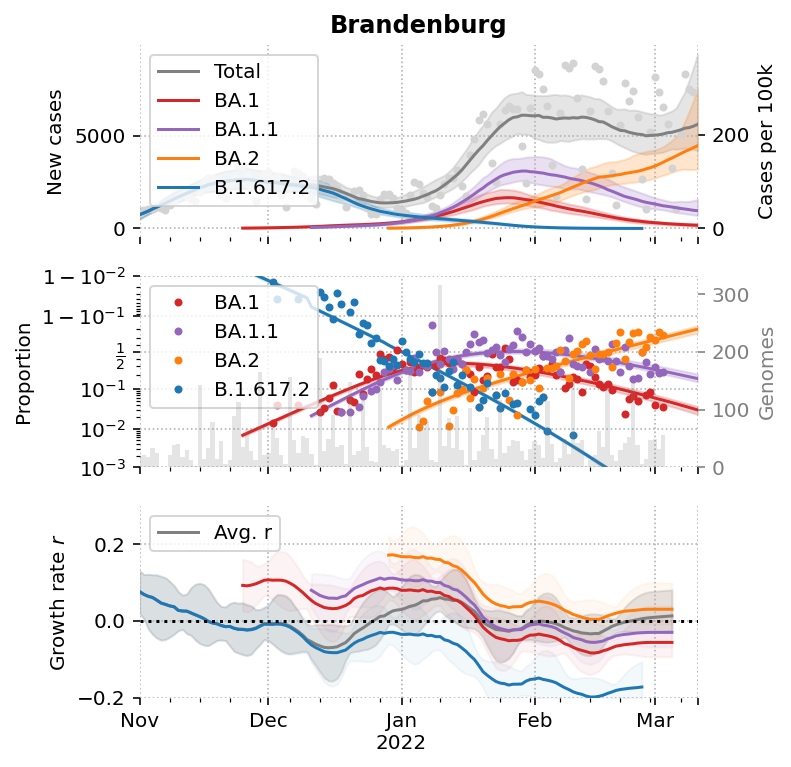

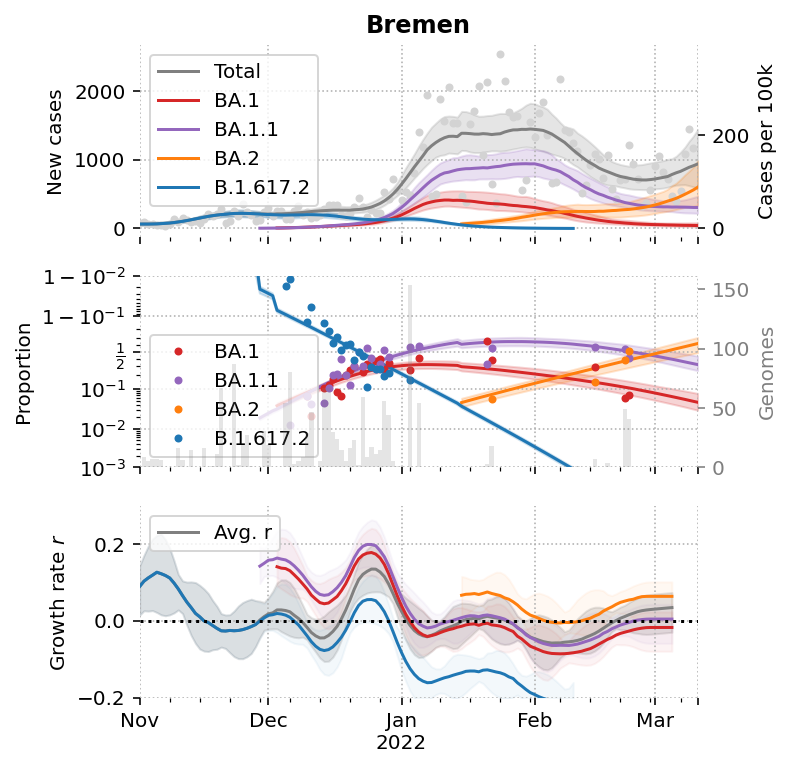

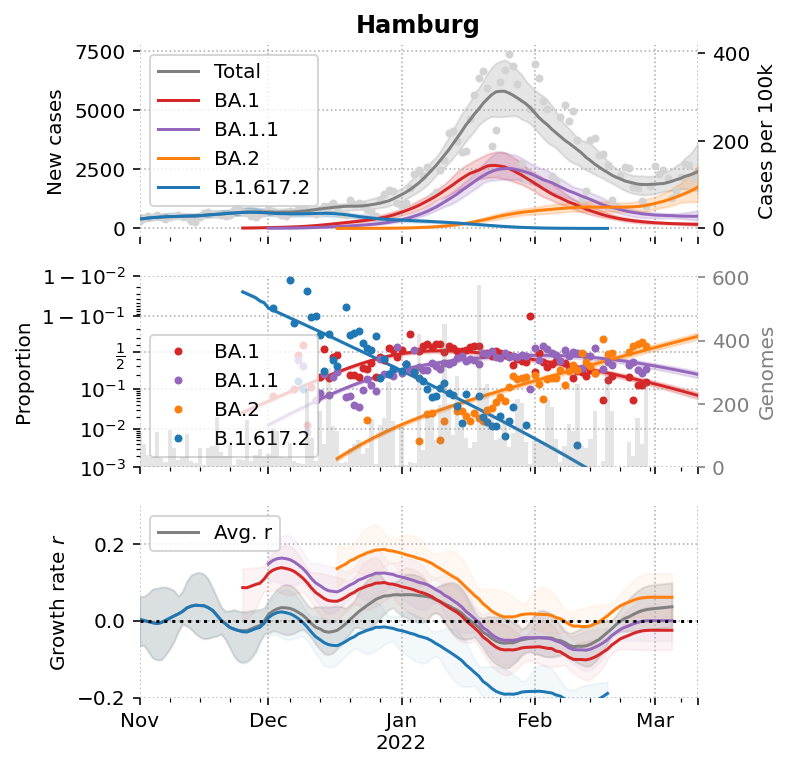

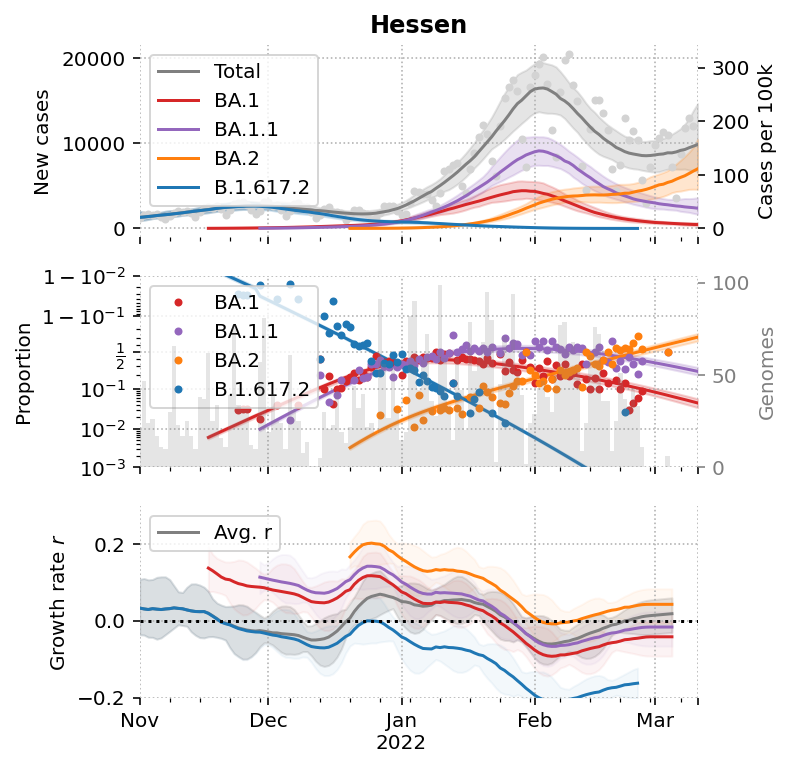

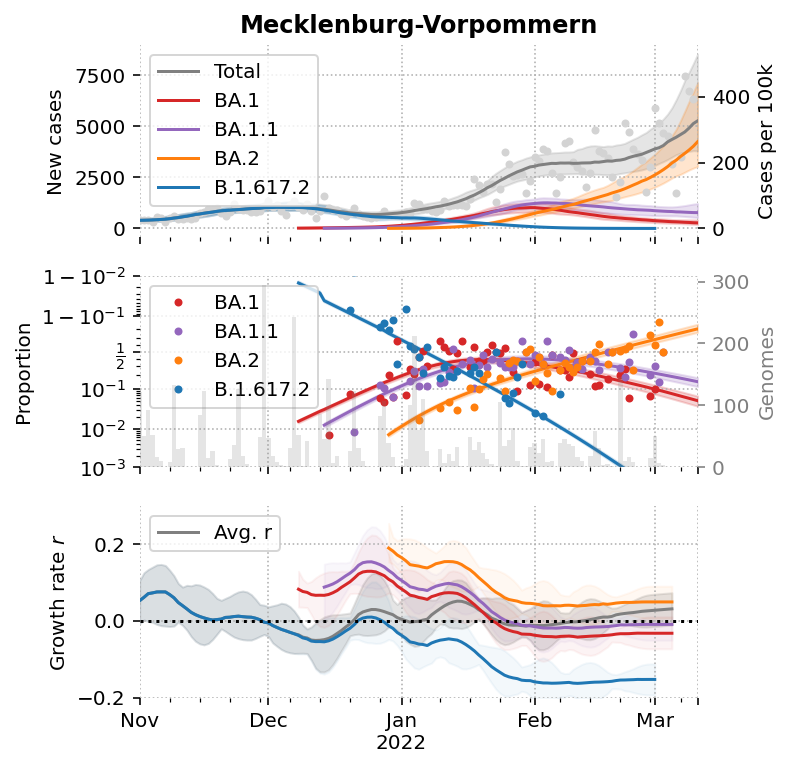

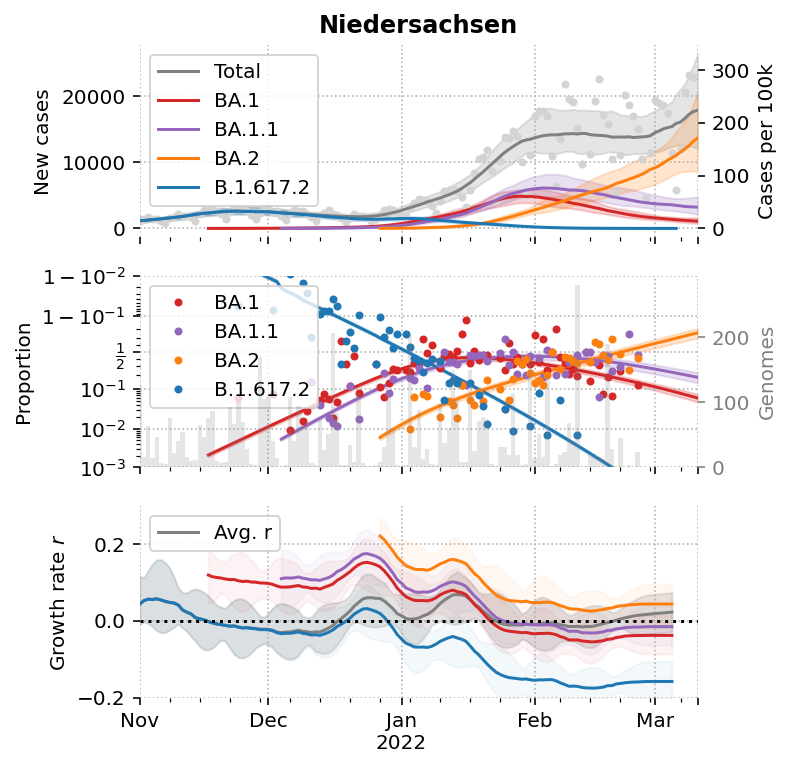

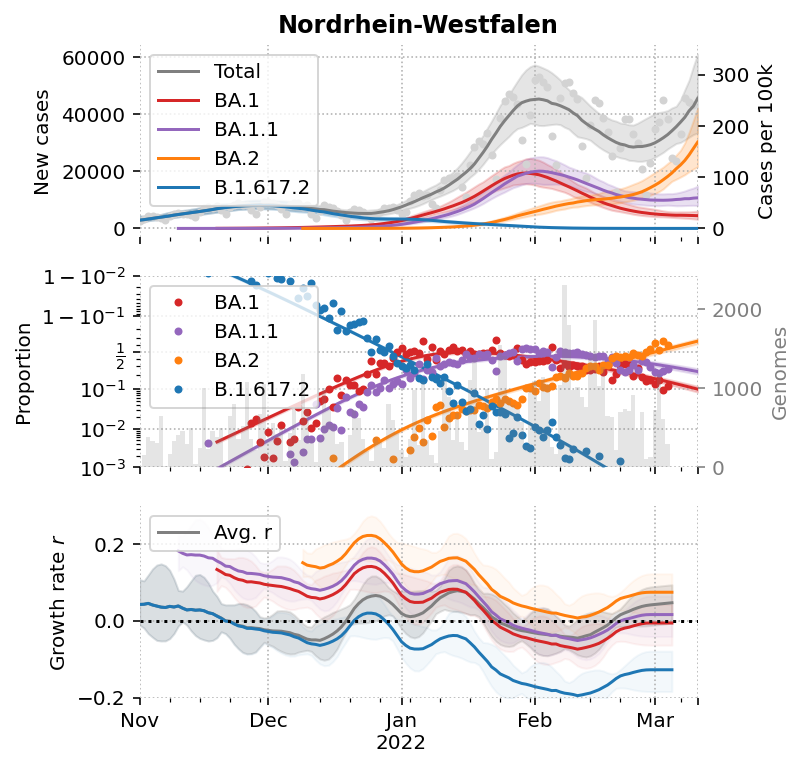

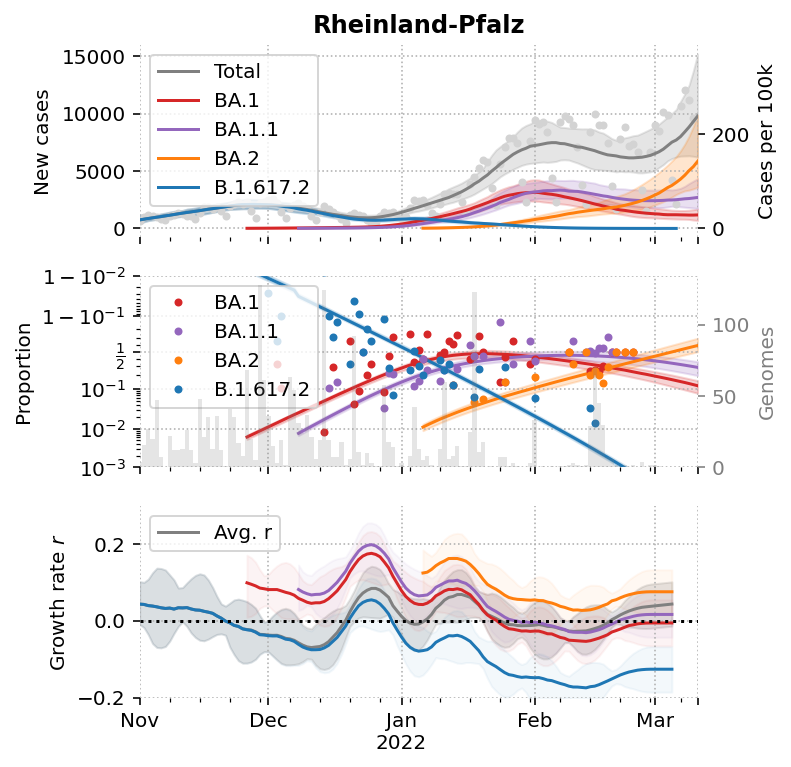

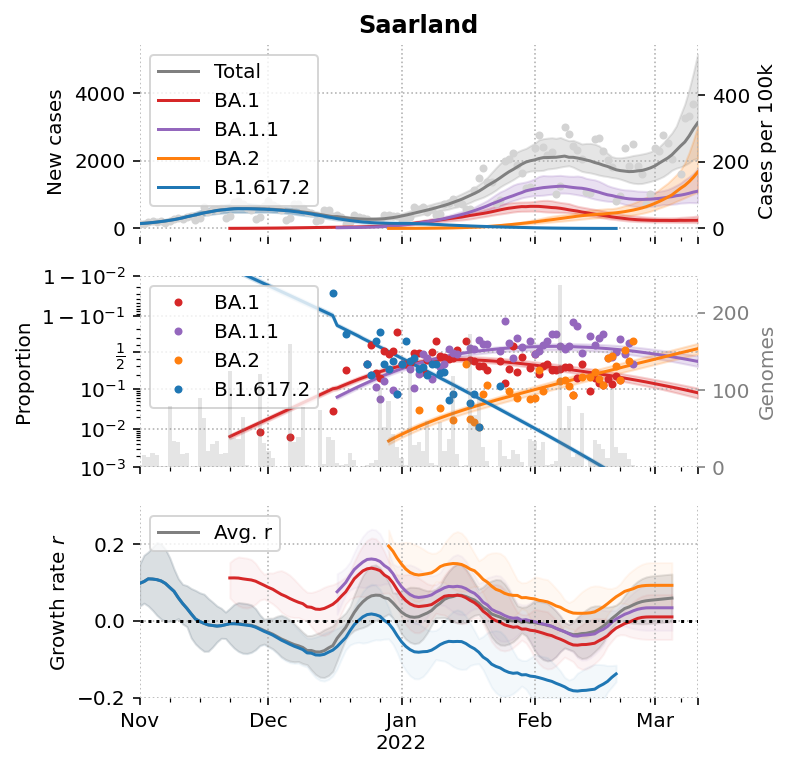

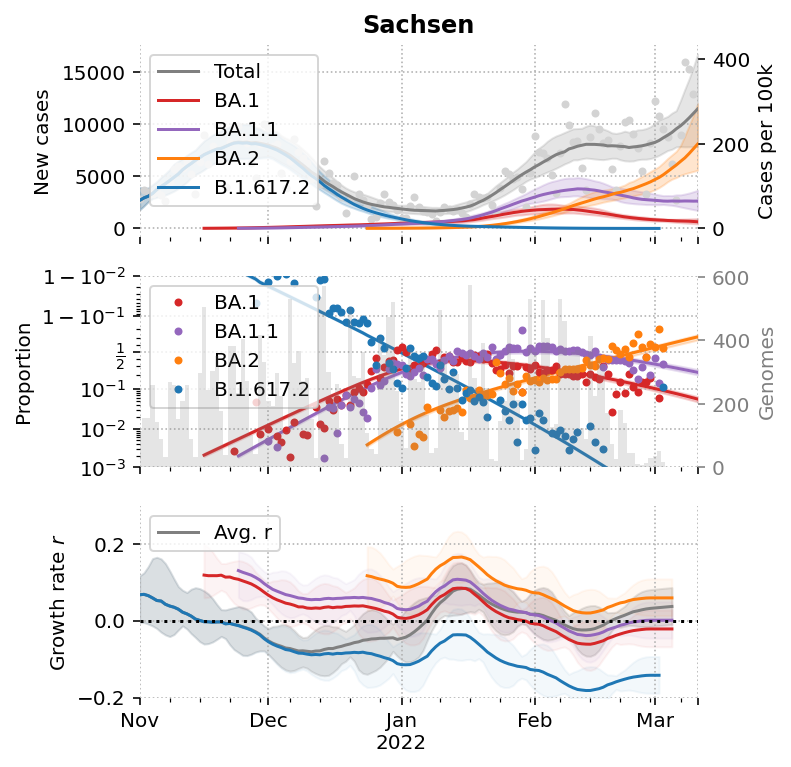

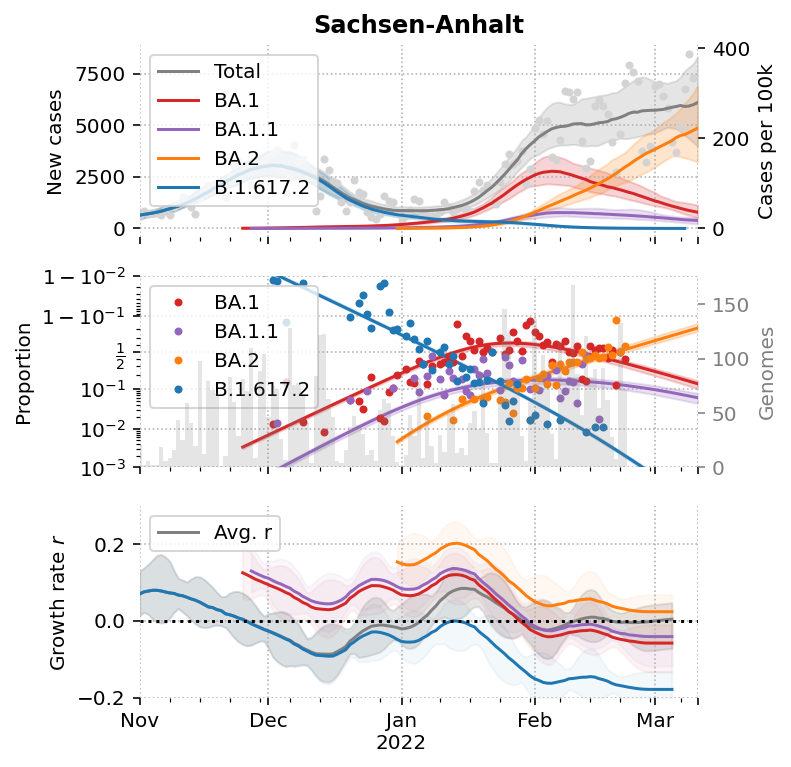

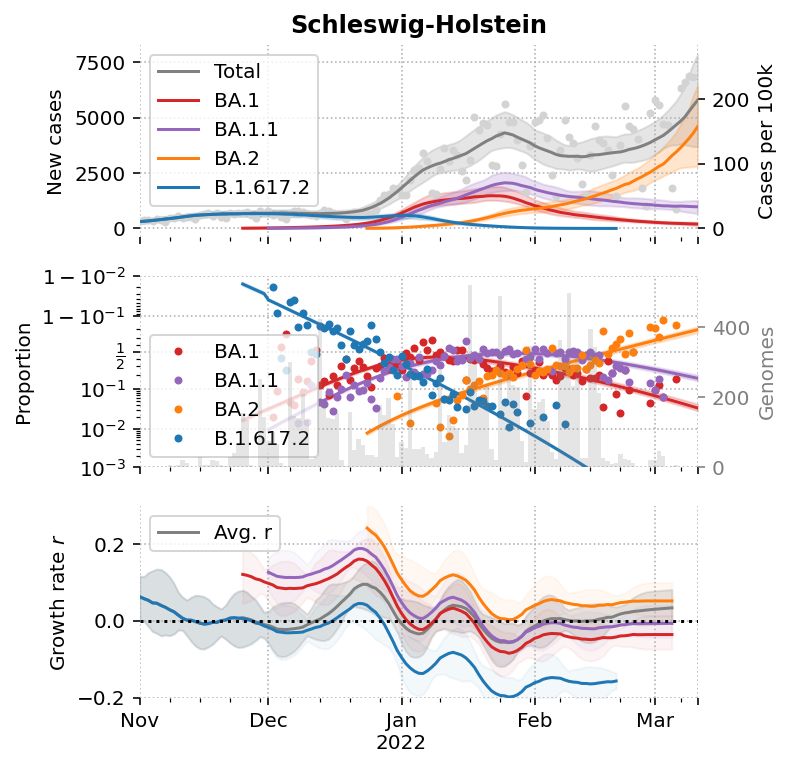

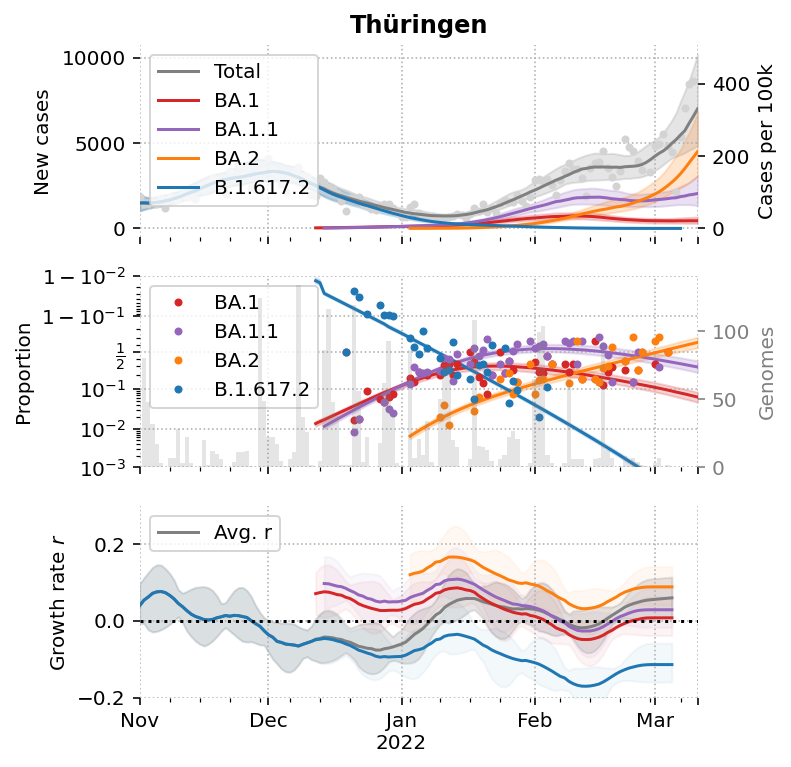

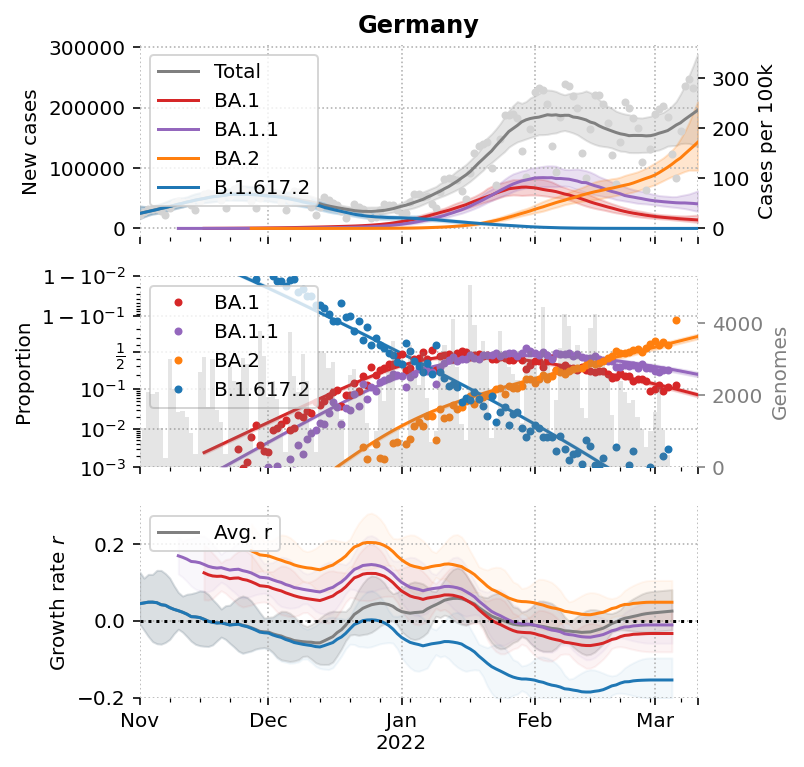

In [818]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 1)[0]
    w = list(set(w) - set([3,4]))
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = genomes.columns[w],
        lin_colors=np.array(['C3',"C4","C1", "C6","C5" ,"C0", "C9","C0"])[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    #ax[0].set_yscale('log')
    #ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-3,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [819]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

0.9999999999999998

In [820]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

Text(0.5, 1.0, 'Germany')

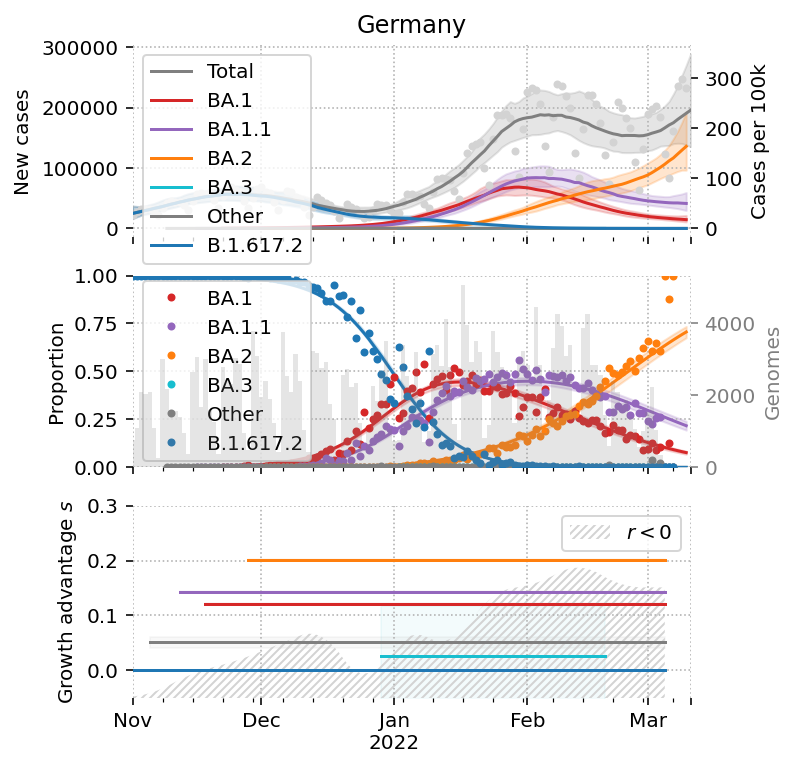

In [821]:
w = np.arange(genomes.shape[-1])
plot_lad(model, -1, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
            bleed_left = 1,
             bleed_right=6,
             show_Rt = False,
             plot_s= True
            )
plt.gcf().get_axes()[2].set_ylim(-0.05,0.3)
plt.gcf().get_axes()[0].set_title("Germany")

In [822]:
λ = model.get_lambda_lineage().mean(0) / model.population[:,np.newaxis, np.newaxis]

In [823]:
λ.shape

(17, 131, 6)

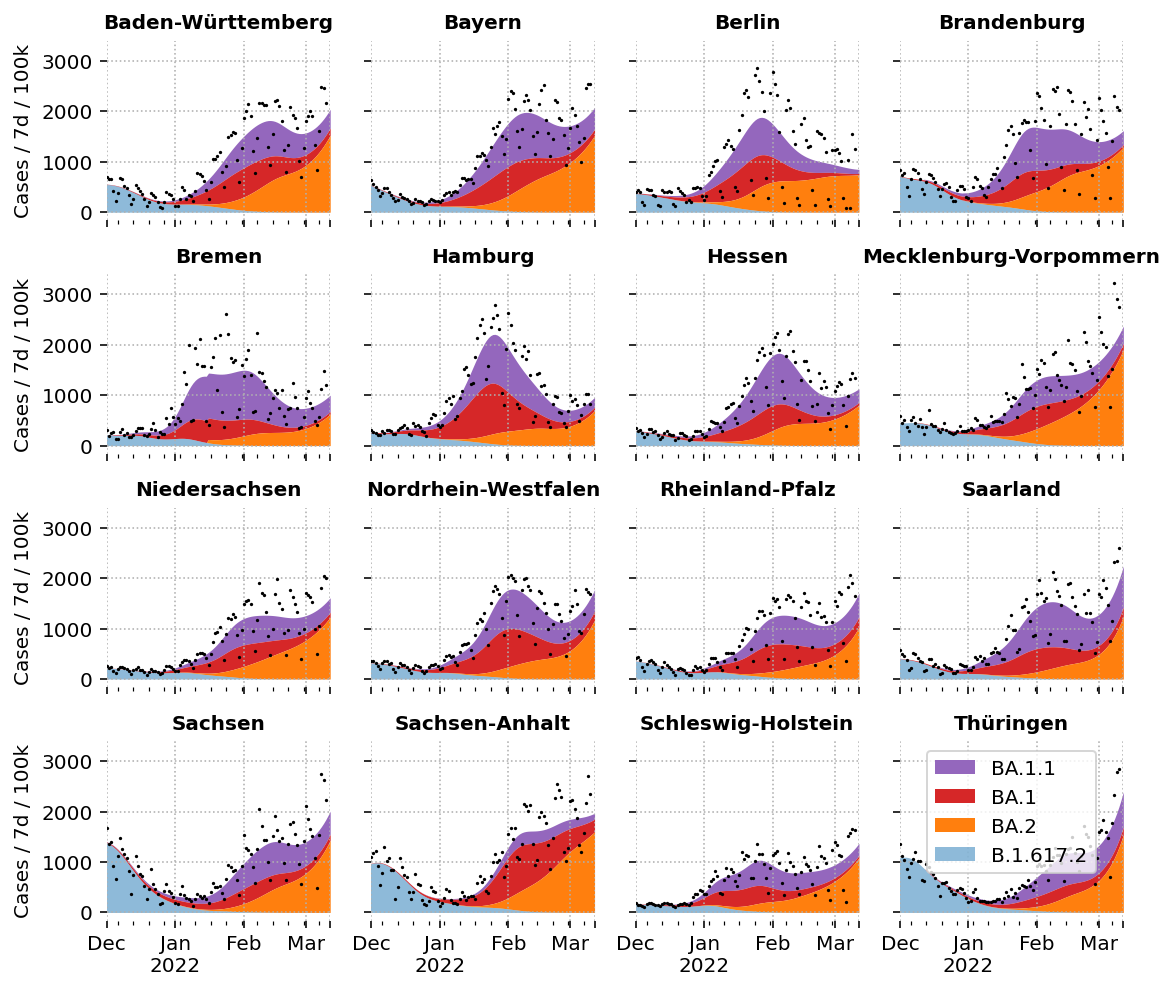

In [824]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=genomes.columns, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y[["B.1.617.2","BA.2","BA.1","BA.1.1","BA.3"]].cumsum(1) * 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    (cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    ax[i].fill_between(y.index, y["BA.1"], y["BA.1.1"], color='C4', alpha=1, lw=0, label="BA.1.1")
    ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [825]:
λ[-1,-1] / λ[-1,-1].sum()

array([7.22354837e-02, 2.08026244e-01, 7.19683639e-01, 1.95612687e-05,
       8.68055147e-06, 2.63924178e-05])

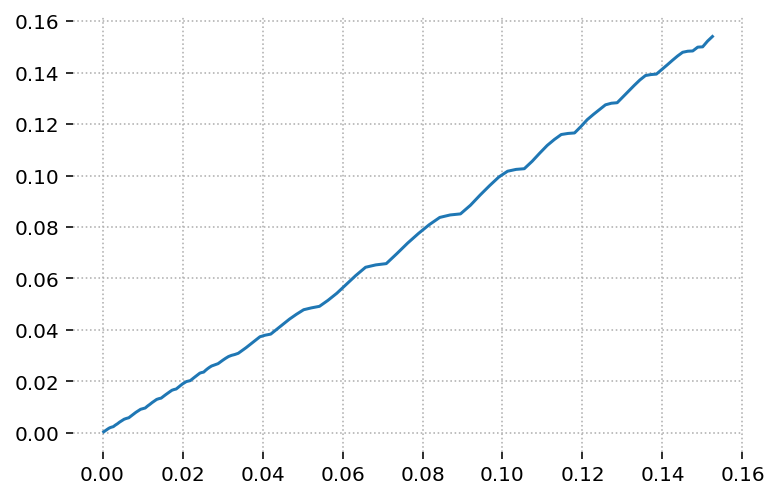

In [826]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [827]:
from genomicsurveillance.misc import get_transmissibility

In [828]:
pd.DataFrame(get_transmissibility(model), columns=genomes.columns, index=cases_land.index.to_list() + ["Germany"])

lineage                     BA.1    BA.1.1      BA.2      BA.3     Other  \
Baden-Württemberg       0.121246  0.143536  0.201808  0.030276  0.046164   
Bayern                  0.121228  0.142934  0.201804  0.032157  0.047557   
Berlin                  0.119873  0.142147  0.201780  0.032157  0.046346   
Brandenburg             0.115253  0.141777  0.201800  0.030608  0.048284   
Bremen                  0.121076  0.143462  0.201665  0.032157  0.049110   
Hamburg                 0.115314  0.140300  0.201807  0.031056  0.047947   
Hessen                  0.117402  0.142788  0.201798  0.030869  0.047108   
Mecklenburg-Vorpommern  0.120873  0.143486  0.201751  0.032157  0.048284   
Niedersachsen           0.121173  0.143500  0.201777  0.032157  0.046533   
Nordrhein-Westfalen     0.121255  0.143532  0.201813  0.030368  0.046046   
Rheinland-Pfalz         0.120851  0.143510  0.201707  0.032157  0.046445   
Saarland                0.119234  0.143527  0.201777  0.032157  0.046279   
Sachsen                 0.120940  0.143536  0.201806  0.030395  0.047544   
Sachsen-Anhalt          0.121288  0.137302  0.201793  0.032097  0.048284   
Schleswig-Holstein      0.115287  0.143441  0.201800  0.030382  0.046486   
Thüringen               0.121206  0.143493  0.201761  0.032157  0.046480   
Germany                 0.121115  0.143516  0.201812  0.033734  0.050621   

lineage                 B.1.617.2  
Baden-Württemberg             0.0  
Bayern                        0.0  
Berlin                        0.0  
Brandenburg                   0.0  
Bremen                        0.0  
Hamburg                       0.0  
Hessen                        0.0  
Mecklenburg-Vorpommern        0.0  
Niedersachsen                 0.0  
Nordrhein-Westfalen           0.0  
Rheinland-Pfalz               0.0  
Saarland                      0.0  
Sachsen                       0.0  
Sachsen-Anhalt                0.0  
Schleswig-Holstein            0.0  
Thüringen                     0.0  
Germany                       0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1       113434                   0.118222  0.002294   
BA.1.1     125950                   0.140403  0.001643   
BA.2        58336                   0.192829  0.000671   
BA.3           66                   0.032157  0.019622   
Other         612                   0.048284  0.004062   
B.1.617.2  237652                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.002294  
BA.1.1                           0.023010  0.001643  
BA.2                             0.082097  0.000671  
BA.3                            -0.088596  0.019622  
Other                           -0.072493  0.004062  
B.1.617.2                       -0.119683  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:912: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


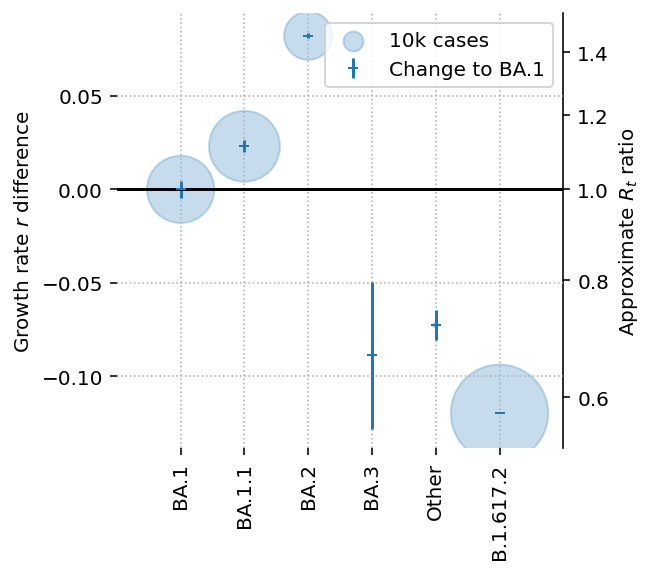

In [829]:
plt.figure(figsize=(4,4))
plot_growth_rates(model, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")

In [830]:
import geopandas as gpd

In [831]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [832]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [833]:
genomes

lineage                       BA.1  BA.1.1  BA.2  BA.3  Other  B.1.617.2
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0     0     0      0        142
                  2021-11-02     0       0     0     0      0        350
                  2021-11-03     0       0     0     0      0        704
                  2021-11-04     0       0     0     0      0       1044
                  2021-11-05     0       0     0     0      0       1210
...                            ...     ...   ...   ...    ...        ...
Thüringen         2022-03-03     0       0     0     0      0          0
                  2022-03-04     1       0     1     0      0          0
                  2022-03-05     0       0     0     0      0          0
                  2022-03-06     0       0     0     0      0          0
                  2022-03-07     0       0     0     0      0          0

[2032 rows x 6 columns]

In [834]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([6.81778900e-02, 2.14362142e-01, 7.16593210e-01, 7.80760726e-04,
       4.87741343e-05, 3.72235902e-05])

In [835]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


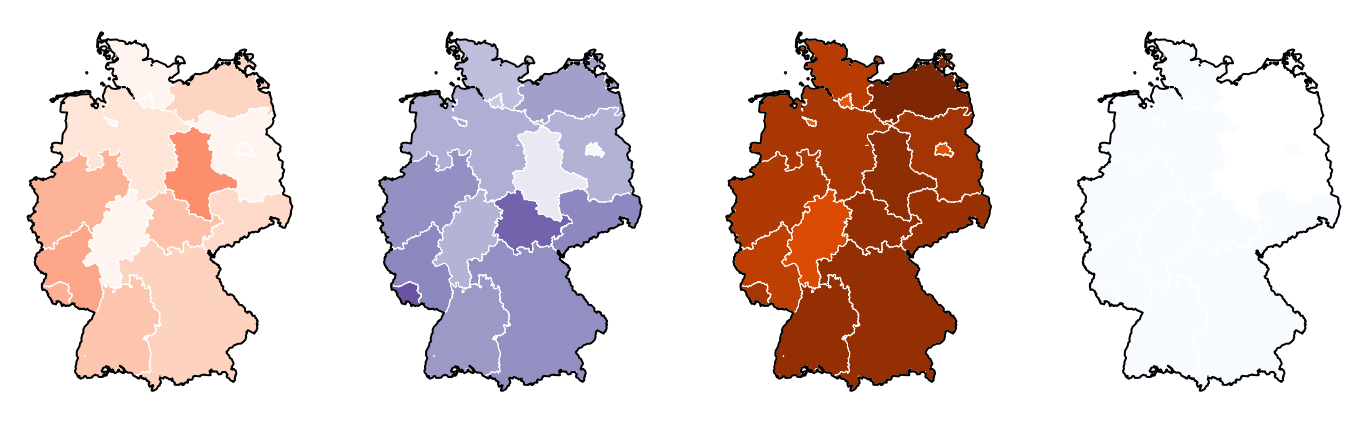

In [836]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,4, figsize=(12,6))
for ax in axs:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:], columns=genomes.columns, index=bl.index), 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="Reds", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
for ax in axs:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [837]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

BA.1        BA.1.1          BA.2        BA.3  \
bundesland                                                                    
Baden-Württemberg       2269.883595   5899.592055  24222.310391    0.074950   
Bayern                  2335.718115   8088.801620  28589.584102    0.000000   
Berlin                   134.773315    426.779476   3882.683857    0.000000   
Brandenburg              176.789362    998.381809   4677.521185    1.246655   
Bremen                    47.038471    316.770260    608.821414    0.000000   
Hamburg                  175.234373    525.529020   1837.922002    0.849584   
Hessen                   461.712436   2459.546200   7228.201427    1.440325   
Mecklenburg-Vorpommern   278.797712    795.651695   4383.229130    0.000000   
Niedersachsen           1112.641276   3297.878254  14036.819754    0.000000   
Nordrhein-Westfalen     4498.513837  10892.555609  30039.664600  151.659573   
Rheinland-Pfalz         1160.637083   2790.166113   6036.047718    0.000000   
Saarland                 251.149515   1149.775946   1749.899796    0.000000   
Sachsen                  662.649296   2675.255851   8310.909065   90.634634   
Sachsen-Anhalt           783.940487    367.447581   4981.983067    0.210659   
Schleswig-Holstein       197.363631    988.417789   4512.919138    0.110571   
Thüringen                459.259329   2123.181809   4667.061118    0.000000   

                           Other  B.1.617.2  
bundesland                                   
Baden-Württemberg       0.380317   1.286234  
Bayern                  0.353514   0.803161  
Berlin                  0.078707   0.028602  
Brandenburg             0.000000   0.125619  
Bremen                  0.013891   0.007213  
Hamburg                 0.019165   0.031578  
Hessen                  7.440314   0.116437  
Mecklenburg-Vorpommern  0.000000   0.227512  
Niedersachsen           0.231465   0.533676  
Nordrhein-Westfalen     0.237312   1.226088  
Rheinland-Pfalz         0.339415   0.568376  
Saarland                0.168782   0.087917  
Sachsen                 0.049458   0.285966  
Sachsen-Anhalt          0.000000   0.603929  
Schleswig-Holstein      0.029477   0.058125  
Thüringen               0.793317   0.673537

In [838]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-3.09732088e-02, -8.65590811e-03,  4.95570332e-02,
        -1.31886766e-01, -1.04861428e-01, -1.52201939e-01],
       [-3.98703517e-02, -1.80406211e-02,  4.06076837e-02,
        -1.61049236e-01, -1.13497658e-01, -1.61049236e-01],
       [-8.42604979e-02, -6.20275920e-02, -2.47252056e-03,
        -2.04181981e-01, -1.54761189e-01, -2.04181981e-01],
       [-5.27942202e-02, -2.63367817e-02,  3.35745930e-02,
        -1.38020867e-01, -1.68093590e-01, -1.68093590e-01],
       [-2.02967687e-02,  1.42655721e-03,  5.98566516e-02,
        -1.41955624e-01, -9.65505224e-02, -1.41955624e-01],
       [-2.50431930e-02, -1.91276670e-04,  6.14689094e-02,
        -1.25811570e-01, -9.25424021e-02, -1.40452505e-01],
       [-4.28281627e-02, -1.76913445e-02,  4.14880044e-02,
        -1.36409360e-01, -9.69307047e-02, -1.60323847e-01],
       [-3.18524184e-02, -9.26045382e-03,  4.89272629e-02,
        -1.52848259e-01, -1.52848259e-01, -1.52848259e-01],
       [-3.69882897e-02, -1.45844047e-02,  4.371

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


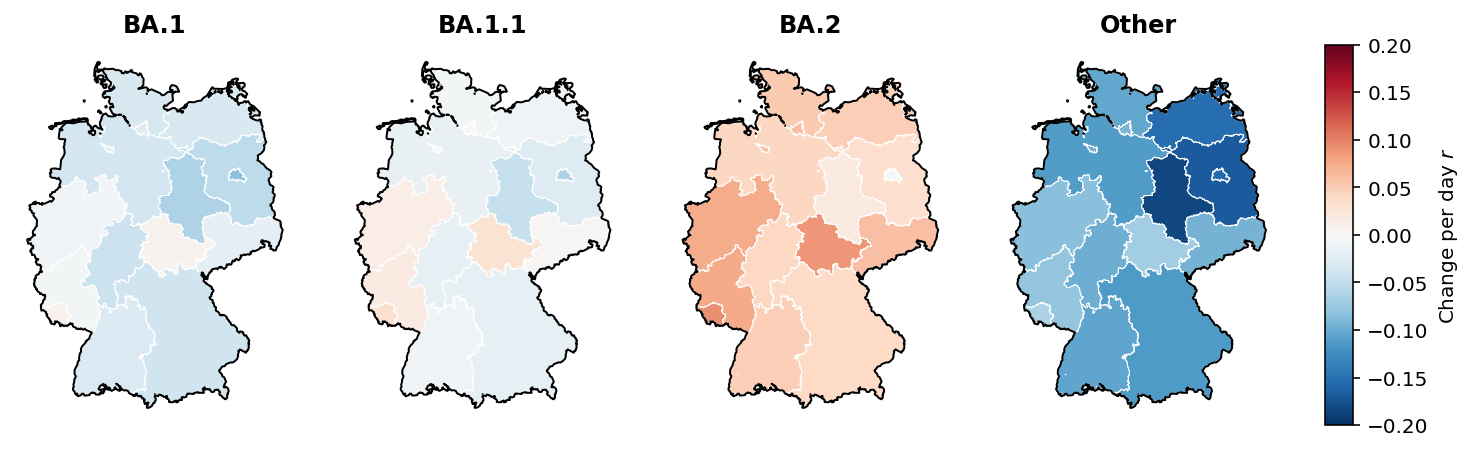

In [839]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [840]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
import re

0.06335055800705663
0.11138045905212543


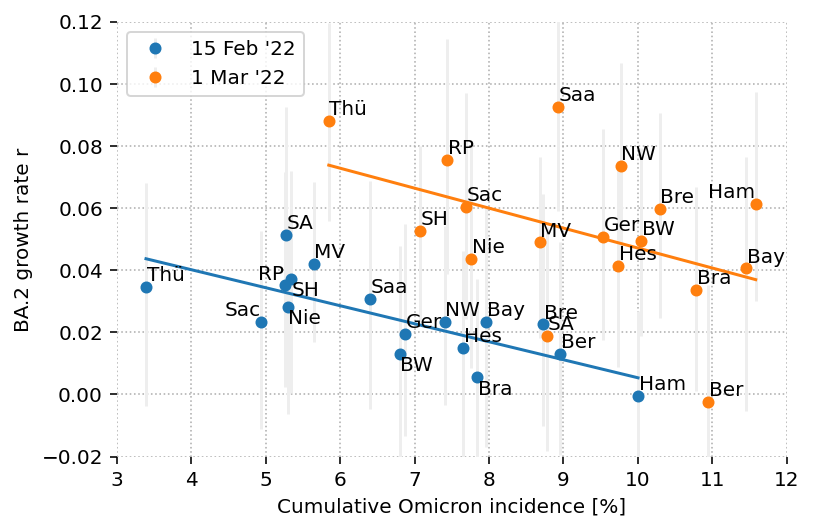

In [871]:
fig, axs = plt.subplots(1,1, figsize=(6,4), sharey=True)
#axs = axs.flatten()
for k,j in enumerate([-24, -10]):
    ax = axs#[0]
    ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,j,2], (0.1, 0.9), axis=0)
    r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,j,:]

    lr = LR()
    x = λ[...,:j,:3].sum((1,2)) * 100
    y = r[:,2]
    lr.fit(x[:,np.newaxis], y)
    ax.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color=f'C{k}', ecolor='#EEEEEE', 
               label=cases_land.columns[j].strftime("%-d %b \'%y"))
    #ax.set_title(cases_land.columns[j].strftime("%-d %b \'%y"))

    l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
    text=[]
    for i in range(x.shape[0]):
        text.append(ax.text(x[i], y[i], l[i], color='k', va='bottom', ha='center'))
    x.sort()
    y = lr.predict(x[:,np.newaxis])
    line = ax.plot(x, y, ls="-", c=f'C{k}')
    #plt.axline((0, lr.intercept_), slope=lr.coef_)
    #plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
    ax.set_xlabel("Cumulative Omicron incidence [%]")
    if k == 0: 
        ax.set_ylabel("BA.2 growth rate r") 
    ax.set_ylim((-0.02,0.12))
    ax.set_xlim((3,12))
    adjust_text(text,) 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                #arrowprops=dict(arrowstyle="-", color='grey', lw=0.5), )
    ax.grid(axis='x', which='major')
    print(lr.intercept_)
ax.legend(loc='upper left')


In [875]:
λ[-1,-1,2]/ λ[-1,-1,:].sum()

0.7196836385050184

In [842]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

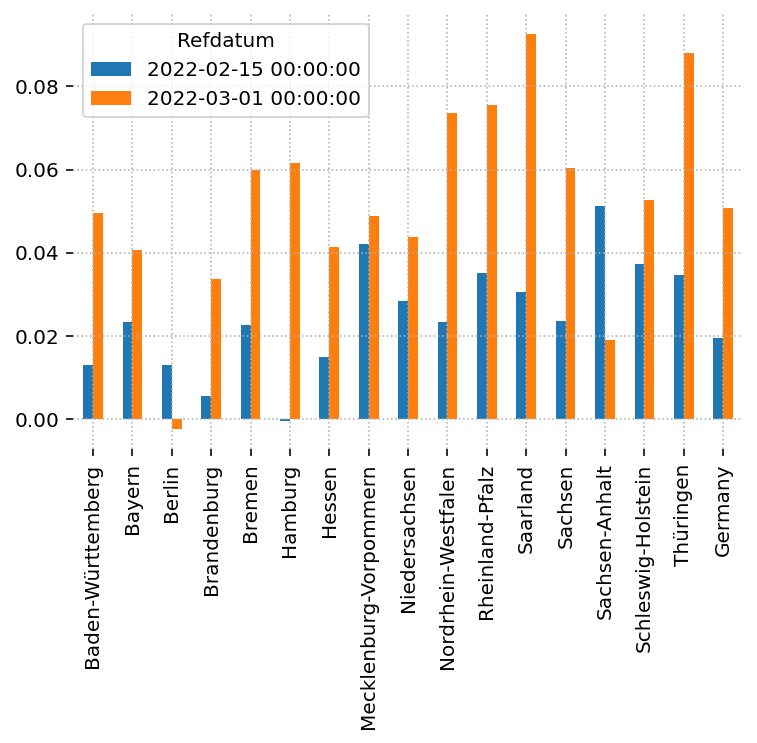

In [843]:
d.plot.bar()

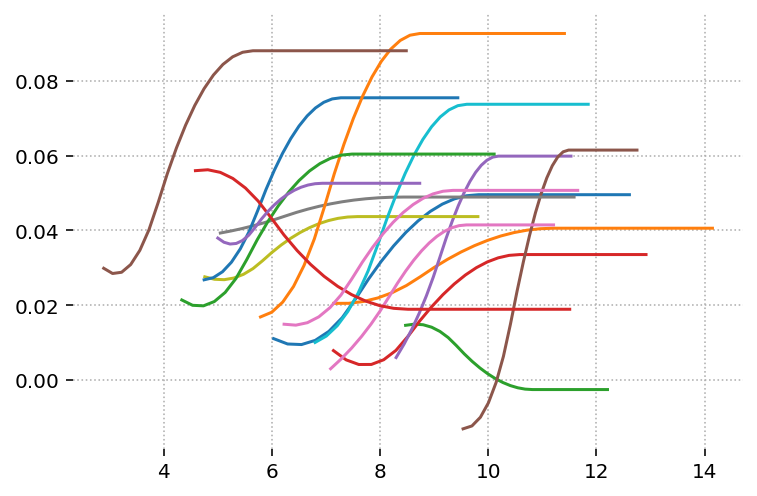

In [844]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


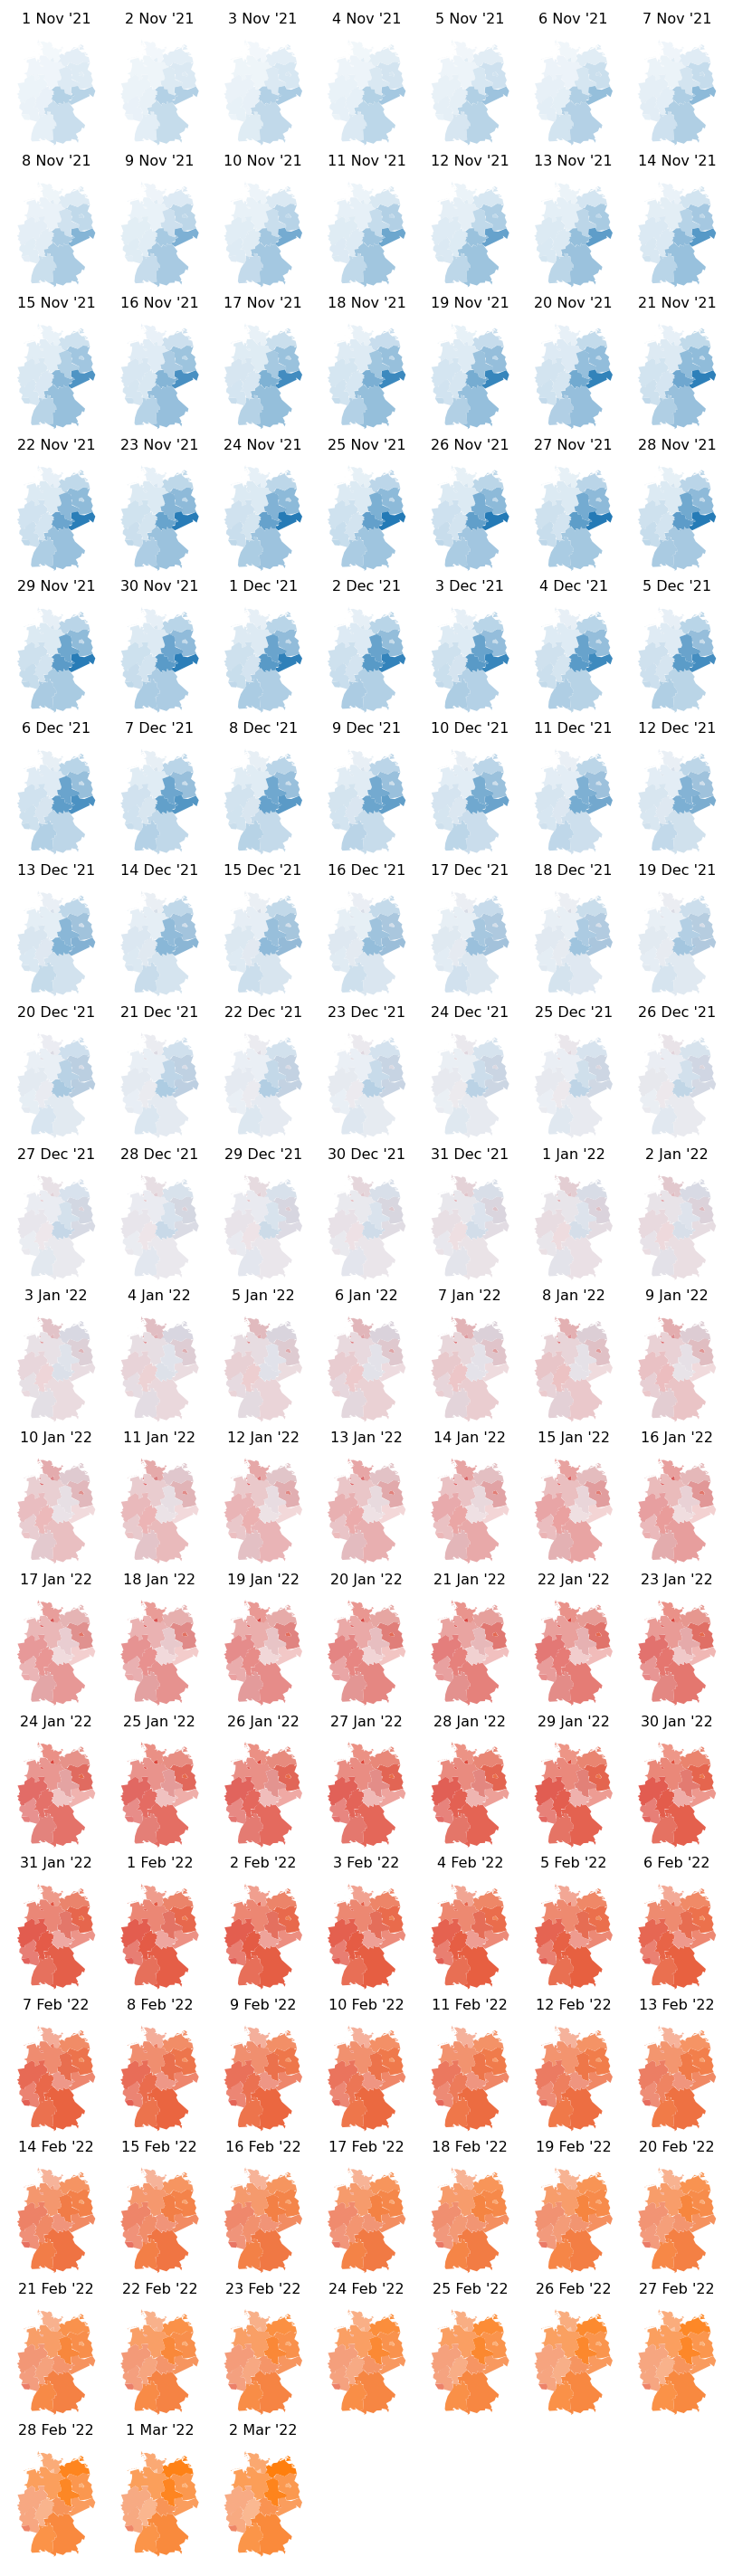

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


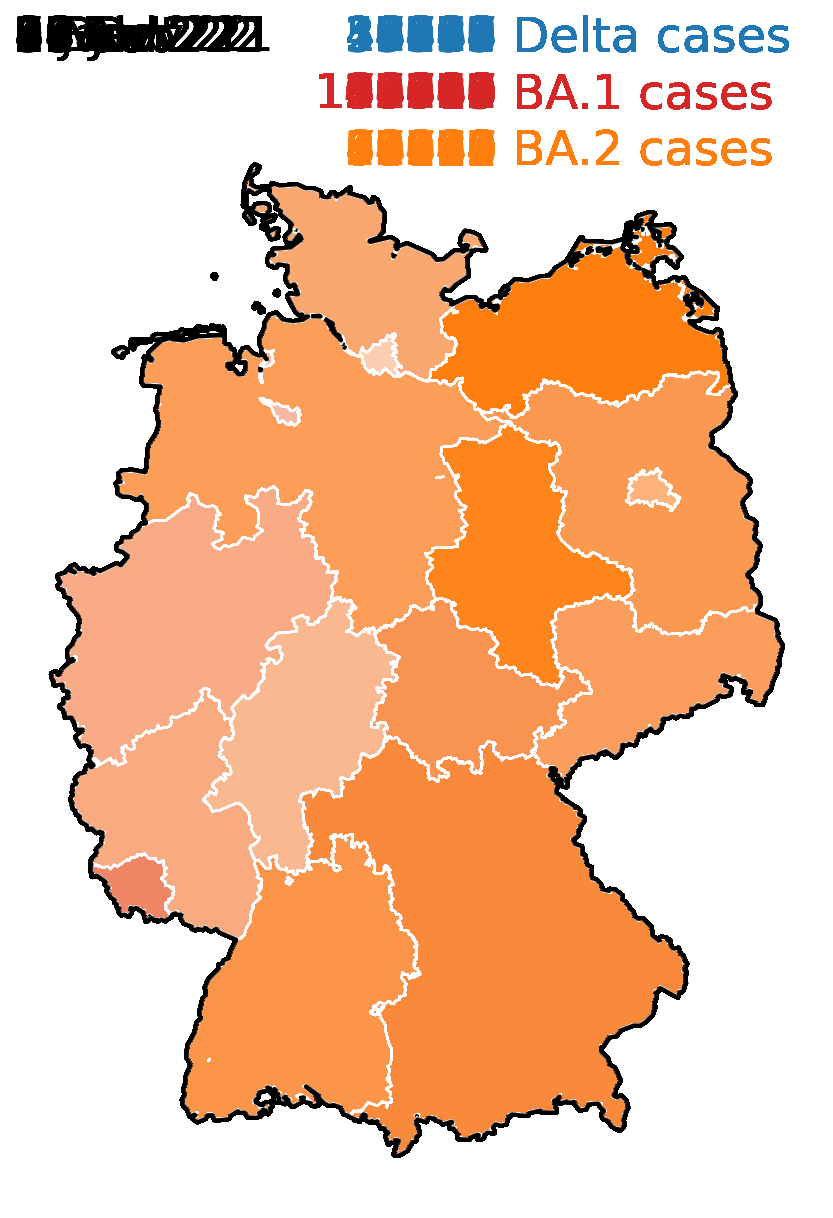

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

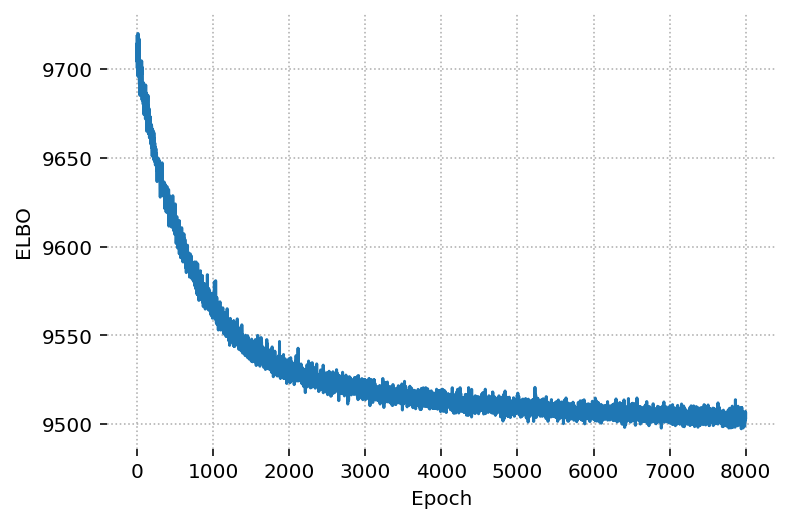

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

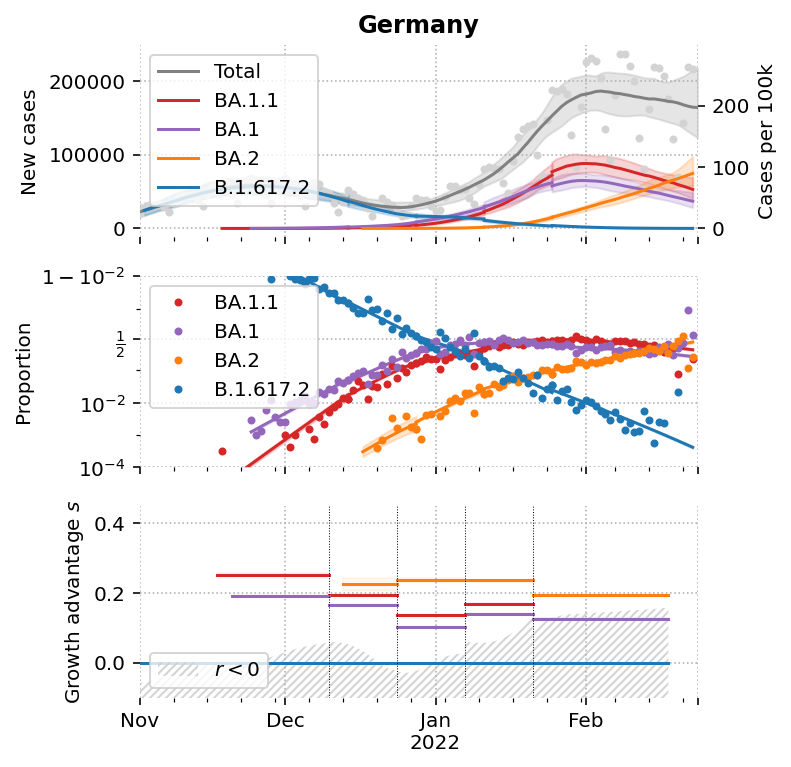

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


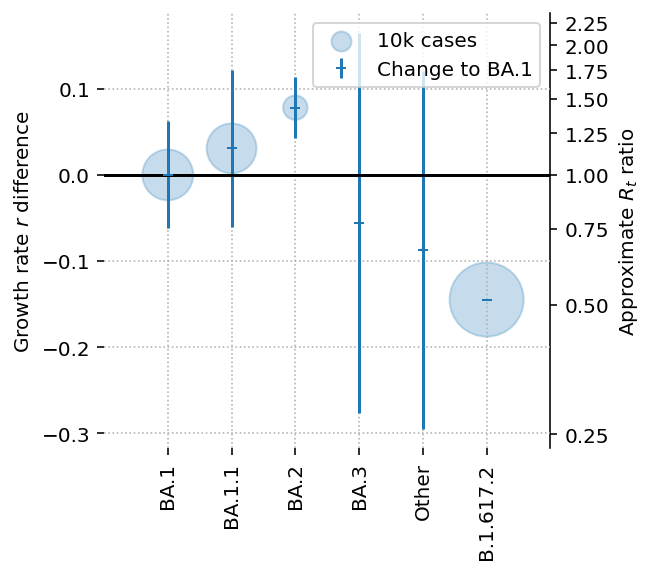

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
